# Hate Speech Detector - PL - Dense model

In [1]:
import os
import pandas as pd
import csv
import numpy as np
import pickle
from klepto.archives import dir_archive

from sklearn.metrics import confusion_matrix

import tensorflow as tf
from tensorflow.keras import Model
from tensorflow.keras.callbacks import Callback
from tensorflow.keras.layers import Input, Dense
from tensorflow.keras.utils import to_categorical

import matplotlib.pyplot as plt
from tqdm.notebook import tqdm
%matplotlib inline

## Load features & labels

In [2]:
archive = dir_archive('hsd/Poleval2019/X_y_dense', {}, cached=True)
archive.load()

features = archive['features']
labels = archive['labels']

In [3]:
features.shape

(11041, 8016)

## Model

The best model was selected using a GridSearch with 5-fold CV.

In [4]:
# hyperparams
LAYERS = 2  # hidden layers count
LR = 0.01  # learning rate
OPTIM = tf.keras.optimizers.Adam  # optimizer
EPOCHS = 15

# params
HL_NODES = 64  # hidden layer nodes
BATCH_SIZE = 200  # size of input batch
INIT = 'random_normal'  # trainable param initializer

In [5]:
SPLIT_RATIO = 0.7

In [6]:
X_train = features[:int(SPLIT_RATIO*len(features))]
y_train = labels[:int(SPLIT_RATIO*len(labels))]
X_test = features[int(SPLIT_RATIO*len(features)):]
y_test = labels[int(SPLIT_RATIO*len(labels)):]

y_train = to_categorical(y_train)
y_test = to_categorical(y_test)

print('Train x: {}'.format(len(X_train)))
print('Train y: {}'.format(len(y_train)))
print('Test x: {}'.format(len(X_test)))
print('Test y: {}'.format(len(y_test)))

Train x: 7728
Train y: 7728
Test x: 3313
Test y: 3313


In [7]:
class MetricsCallback(Callback):
    def __init__(self):
        super(MetricsCallback, self).__init__()
        self.val_f1s0 = []
        self.val_f1s1 = []
    
    def on_epoch_end(self, epoch, logs={}):
        val_predict = np.asarray(tf.argmax(self.model.predict(X_test), axis=1))
        val_true = np.asarray(tf.argmax(y_test, axis=1))
        c_m = confusion_matrix(val_true, val_predict, labels=[0, 1])
        self.val_f1s0.append(2*float(c_m[0][0])/(2*float(c_m[0][0]) + c_m[0][1] + c_m[1][0]))
        self.val_f1s1.append(2*float(c_m[1][1])/(2*float(c_m[1][1]) + c_m[1][0] + c_m[0][1]))

In [8]:
class DenseModel():
    def __init__(self, input_shape, name='dense_model', **kwargs):
        # hyperparams
        self.layers = LAYERS if 'layers' not in kwargs else kwargs['layers']
        self.lr = LR if 'lr' not in kwargs else kwargs['lr']
        self.optim = OPTIM(learning_rate=self.lr) if 'optim' not in kwargs else kwargs['optim'](learning_rate=self.lr)
        self.epochs = EPOCHS if 'epochs' not in kwargs else kwargs['epochs']
        
        # params
        self.hl_nodes = HL_NODES if 'hl_nodes' not in kwargs else kwargs['hl_nodes']
        self.batch_size = BATCH_SIZE if 'batch_size' not in kwargs else kwargs['batch_size']
        self.init = INIT if 'init' not in kwargs else kwargs['init']
        
        # layers
        inputs = Input(shape=input_shape, name='features')
        x = Dense(self.hl_nodes, activation='relu', name='dense_1',
                  kernel_initializer=self.init, bias_initializer=self.init)(inputs)
        for layer in range(self.layers)[1:]:
            x = Dense(self.hl_nodes, activation='relu', name='dense_{}'.format(layer+1),
                      kernel_initializer=self.init, bias_initializer=self.init)(x)
        outputs = Dense(2, activation='softmax', name='predictions',
                        kernel_initializer=self.init, bias_initializer=self.init)(x)
        
        self.name = name
        self.model = Model(inputs=inputs, outputs=outputs, name=name)
        self.mc = MetricsCallback()
    
    def summary(self):
        return self.model.summary()
    
    def compile(self):
        self.model.compile(optimizer=self.optim,
                           loss=tf.keras.losses.CategoricalCrossentropy(),
                           metrics=[tf.keras.metrics.CategoricalAccuracy()])
    
    def fit(self, X_tr, y_tr, X_ev, y_ev):
        return self.model.fit(X_tr, y_tr, batch_size=self.batch_size, epochs=self.epochs,
                              validation_data=(X_ev, y_ev), callbacks=[self.mc])
    
    def predict(self, X_t):
        return self.model.predict(X_t)

In [9]:
def models_comparison_bars(df, title, save_file=None):
    fig, axs = plt.subplots(1, 3, figsize=(16, 4))
    
    x = range(1, len(df) + 1)
    acc = df['acc'].values
    f1s0 = df['f1s0'].values
    f1s1 = df['f1s1'].values
    
    axs[0].bar(x, acc, color='r')
    axs[0].set_xlabel('Model number')
    axs[0].set_ylabel('Accuracy')
    axs[0].set_title('Accuracy | max for: {}'.format(np.argmax(acc)))
    
    axs[1].bar(x, f1s0, color='b')
    axs[1].set_xlabel('Model number')
    axs[1].set_ylabel('F1 score (0)')
    axs[1].set_title('F1 score (0) | max for: {}'.format(np.argmax(f1s0)))
    
    axs[2].bar(x, f1s1, color='m')
    axs[2].set_xlabel('Model number')
    axs[2].set_ylabel('F1 score (1)')
    axs[2].set_title('F1 score (1) | max for: {}'.format(np.argmax(f1s1)))
    
    fig.suptitle(title)
    
    if save_file:
        plt.savefig(save_file)
    plt.show()

## Model hyperparams researching

In [10]:
layers_options = [2, 5, 8]
lr_options = [0.1, 0.01, 0.001]
optim_options = [tf.keras.optimizers.Adam, tf.keras.optimizers.SGD]
epochs_options = [5, 10, 15]

hp_options = []
for epochs in [epochs_options[-1]]:  # changed to process 15 epochs (eval. after each 5)
    for lr in lr_options:
        for optim in optim_options:
            for layer in layers_options:
                hp_options.append({'lr': lr, 'optim': optim, 'epochs': epochs, 'layers': layer})

In [11]:
pd.DataFrame(hp_options).head()

,epochs,layers,lr,optim
0,15,2,0.1,<class 'tensorflow.python.keras.optimizer_v2.a...
1,15,5,0.1,<class 'tensorflow.python.keras.optimizer_v2.a...
2,15,8,0.1,<class 'tensorflow.python.keras.optimizer_v2.a...
3,15,2,0.1,<class 'tensorflow.python.keras.optimizer_v2.g...
4,15,5,0.1,<class 'tensorflow.python.keras.optimizer_v2.g...


In [12]:
if not os.path.exists('results/pl_dense/hyperparams_research.csv'):
    hp_results = []
    for i, opts in enumerate(hp_options):
        print('\nResearching for {}/{} | Hyperparams: {}\n'.format(i+1, len(hp_options), opts))

        hp_model = DenseModel(input_shape=(8016, ), **opts)
        hp_model.compile()
        hp_history = hp_model.fit(X_train, y_train, X_test, y_test)

        # append means for 5, 10 and 15 epochs
        for eps in epochs_options:
            hp_results.append({'acc': np.mean(hp_history.history['categorical_accuracy'][:eps]),
                               'val_acc': np.mean(hp_history.history['val_categorical_accuracy'][:eps]),
                               'loss': np.mean(hp_history.history['val_loss'][:eps]),
                               'f1s0': np.mean(hp_model.mc.val_f1s0[:eps]),
                               'f1s1': np.mean(hp_model.mc.val_f1s1[:eps])})
    
    hp_results_df = pd.DataFrame(hp_results)
    hp_results_df.to_csv('results/pl_dense/hyperparams_research.csv')
else:
    hp_results_df = pd.read_csv('results/pl_dense/hyperparams_research.csv', index_col=0)

In [13]:
hp_results_df.head()

,acc,f1s0,f1s1,loss,val_acc
0,0.951630,0.952265,0.601681,0.285456,0.915545
1,0.956910,0.956555,0.668592,0.252505,0.923694
2,0.955486,0.953030,0.603340,0.280402,0.916772
3,0.935093,0.917143,0.000000,8.976652,0.846967
4,0.936620,0.917143,0.000000,11.891177,0.846967


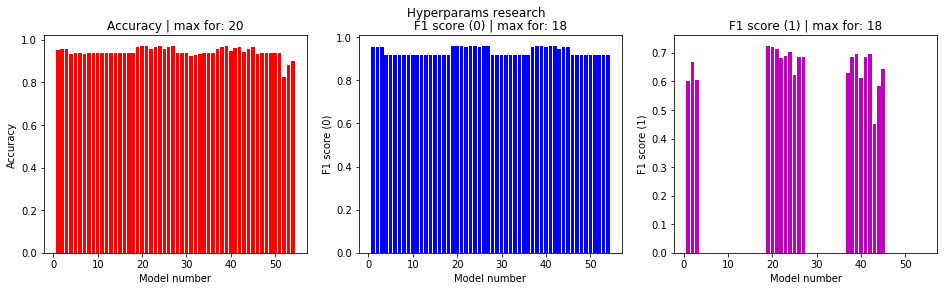

In [14]:
models_comparison_bars(hp_results_df, title='Hyperparams research', save_file='results/pl_dense/hyperparams_research.png')

In [15]:
best_h_num = 18
'Best one: {} with {} run epochs'.format(hp_options[best_h_num/3], (best_h_num%3)*5)

"Best one: {'optim': <class 'tensorflow.python.keras.optimizer_v2.adam.Adam'>, 'epochs': 15, 'lr': 0.01, 'layers': 2} with 0 run epochs"

## Model params researching

In [16]:
hl_nodes_options = [64, 128]
batch_size_options = [100, 200]
init_options = ['random_uniform', 'random_normal']

p_options = []
for hl_nodes in hl_nodes_options:
    for batch_size in batch_size_options:
        for init in init_options:
            p_options.append({'hl_nodes': hl_nodes, 'batch_size': batch_size, 'init': init})

In [17]:
pd.DataFrame(p_options).head()

,batch_size,hl_nodes,init
0,100,64,random_uniform
1,100,64,random_normal
2,200,64,random_uniform
3,200,64,random_normal
4,100,128,random_uniform


In [18]:
if not os.path.exists('results/pl_dense/params_research.csv'):
    p_results = []
    for i, opts in enumerate(p_options):
        print('\nResearching for {}/{} | Hyperparams: {}\n'.format(i+1, len(p_options), opts))

        p_model = DenseModel(input_shape=(8016, ), **opts)
        p_model.compile()
        p_history = p_model.fit(X_train, y_train, X_test, y_test)

        p_results.append({'acc': np.mean(p_history.history['categorical_accuracy']),
                          'val_acc': np.mean(p_history.history['val_categorical_accuracy']),
                          'loss': np.mean(p_history.history['val_loss']),
                          'f1s0': np.mean(p_model.mc.val_f1s0),
                          'f1s1': np.mean(p_model.mc.val_f1s1)})
    
    p_results_df = pd.DataFrame(p_results)
    p_results_df.to_csv('results/pl_dense/params_research.csv')
else:
    p_results_df = pd.read_csv('results/pl_dense/params_research.csv', index_col=0)

In [19]:
p_results_df.head()

,acc,f1s0,f1s1,loss,val_acc
0,0.969746,0.955632,0.675214,0.239297,0.922004
1,0.972438,0.960063,0.717536,0.230148,0.930053
2,0.969850,0.956630,0.681780,0.229274,0.923715
3,0.971273,0.960744,0.731127,0.223136,0.931542
4,0.972162,0.960253,0.722398,0.240864,0.930496


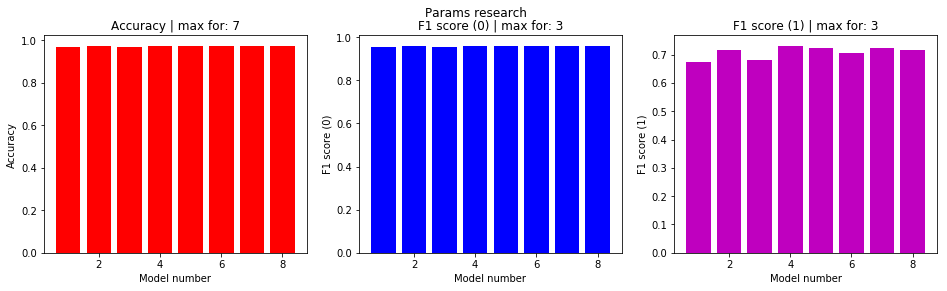

In [20]:
models_comparison_bars(p_results_df, title='Params research', save_file='results/pl_dense/params_research.png')

In [21]:
best_num = 3
'Best one: {}'.format(p_options[best_num])

"Best one: {'hl_nodes': 64, 'init': 'random_normal', 'batch_size': 200}"

## Best model

In [22]:
model = DenseModel(input_shape=(8016, ))
model.compile()
history = model.fit(X_train, y_train, X_test, y_test)

Train on 7728 samples, validate on 3313 samples
Epoch 1/15
7728/7728 [==============================] - 2s 202us/sample - loss: 0.2269 - categorical_accuracy: 0.9318 - val_loss: 0.2094 - val_categorical_accuracy: 0.9200
Epoch 2/15
7728/7728 [==============================] - 1s 109us/sample - loss: 0.0955 - categorical_accuracy: 0.9652 - val_loss: 0.1715 - val_categorical_accuracy: 0.9381
Epoch 3/15
7728/7728 [==============================] - 1s 113us/sample - loss: 0.0834 - categorical_accuracy: 0.9695 - val_loss: 0.1591 - val_categorical_accuracy: 0.9423
Epoch 4/15
7728/7728 [==============================] - 1s 114us/sample - loss: 0.0801 - categorical_accuracy: 0.9683 - val_loss: 0.1712 - val_categorical_accuracy: 0.9390
Epoch 5/15
7728/7728 [==============================] - 1s 107us/sample - loss: 0.0731 - categorical_accuracy: 0.9696 - val_loss: 0.2556 - val_categorical_accuracy: 0.9260
Epoch 6/15
7728/7728 [==============================] - 1s 110us/sample - loss: 0.0671 - cat

In [23]:
predictions = model.predict(X_test)
y_true = tf.argmax(y_test, axis=1)
y_pred = tf.argmax(predictions, axis=1)

conf_mat = tf.math.confusion_matrix(labels=y_true, predictions=y_pred, num_classes=2).numpy()
acc = float(np.sum(np.diag(conf_mat)))/np.sum(np.sum(conf_mat))

## Visualizations

In [30]:
def plots(y_ss, y_labels, colors, title, file_name=None):
    x_s = range(1, len(y_ss[0])+1)
    for y_s, y_label, color in zip(y_ss, y_labels, colors):
        plt.plot(x_s, y_s, color, label=y_label)
    plt.xlabel('Epoch')
    plt.ylabel('Metrics')
    tick_marks = np.arange(1, len(x_s) + 1)
    plt.xticks(tick_marks, x_s)
    plt.title(title)
    
    plt.legend(loc='best', frameon=False)
    
    if file_name:
        plt.savefig(file_name)
    plt.show()

def twinx_plot(y1_s, y2_s, x_label, y1_label, y2_label, title, colors=['r', 'b'], file_name=None):
    fig, ax1 = plt.subplots()
    
    ax1.set_xlabel(x_label)
    ax1.set_xticks(range(1, len(y1_s)+1))
    
    ax1.set_ylabel(y1_label, color=colors[0])
    ax1.plot(range(1, len(y1_s)+1), y1_s, color=colors[0])
    ax1.tick_params(axis='y', labelcolor=colors[0])
    
    ax2 = ax1.twinx()  # instantiate a second axes that shares the same x-axis
    
    ax2.set_ylabel(y2_label, color=colors[1])  # we already handled the x-label with ax1
    ax2.plot(range(1, len(y2_s)+1), y2_s, color=colors[1])
    ax2.tick_params(axis='y', labelcolor=colors[1])
    
    fig.tight_layout()  # otherwise the right y-label is slightly clipped
    plt.title(title)
    
    if file_name:
        plt.savefig(file_name)
    plt.show()

def confusion_matrix_plot(conf_mat, cls, x_label, y_label, title, file_name=None):
    plt.imshow(conf_mat, interpolation='nearest', cmap=plt.cm.Wistia)
    plt.title(title)
    plt.ylabel(y_label)
    plt.xlabel(x_label)
    tick_marks = np.arange(len(cls))
    plt.grid(False)
    plt.xticks(tick_marks, cls, rotation=45)
    plt.yticks(tick_marks, cls)
    
    for i in range(len(cls)):
        for j in range(len(cls)):
            plt.text(j - 0.2, i, str(conf_mat[i][j]), fontsize=16)
    
    if file_name:
        plt.savefig(file_name)
    plt.show()

def class_distribution_hist(y_true, y_pred, cls, x_label, y_label, title, file_name=None):
    pd.Series([y_true, y_pred]).hist()
    plt.title(title)
    plt.ylabel(y_label)
    plt.xlabel(x_label)
    tick_marks = np.arange(len(cls))
    plt.xticks(tick_marks, cls)
    
    if file_name:
        plt.savefig(file_name)
    plt.show()

In [31]:
classes = ['no hate', 'hate speech']

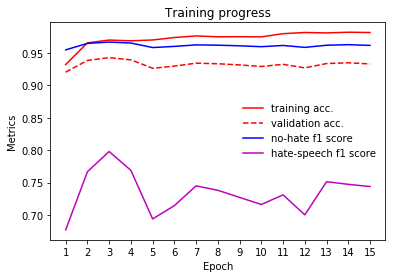

In [32]:
plots([history.history['categorical_accuracy'],
       history.history['val_categorical_accuracy'],
       model.mc.val_f1s0,
       model.mc.val_f1s1],
      ['training acc.', 'validation acc.', 'no-hate f1 score', 'hate-speech f1 score'],
      ['-r', '--r', 'b', 'm'],
      title='Training progress', file_name='results/pl_dense/train_progress.png')

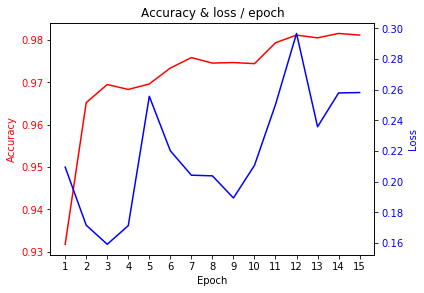

In [33]:
twinx_plot(history.history['categorical_accuracy'], history.history['val_loss'],
          x_label='Epoch', y1_label='Accuracy', y2_label='Loss', title='Accuracy & loss / epoch',
          file_name='results/pl_dense/acc_loss.png')

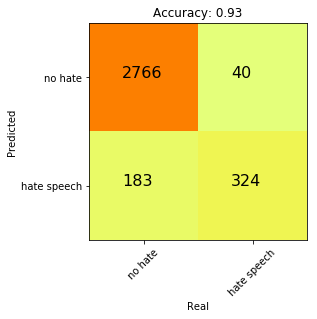

In [34]:
confusion_matrix_plot(conf_mat, cls=classes,
                      x_label='Real', y_label='Predicted',
                      title='Accuracy: {}'.format(round(acc, 2)),
                      file_name='results/pl_dense/cm.png')

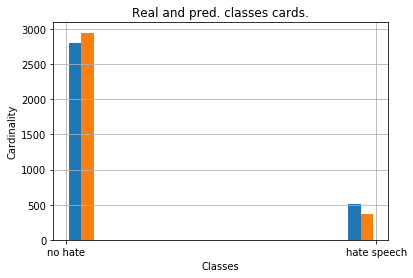

In [35]:
class_distribution_hist(y_true, y_pred, cls=classes,
                        x_label='Classes', y_label='Cardinality', title='Real and pred. classes cards.',
                        file_name='results/pl_dense/cards.png')